# DCGAN Hyperparameter Tuning Experiments
## Component 2: Hyperparameter Optimization (10 marks)

### Experiments:
1. **Learning Rates**: [0.0001, 0.0002, 0.0005, 0.001]
2. **Batch Sizes**: [32, 64, 128]
3. **Latent Dimensions**: [32, 64, 100, 128]
4. **Beta Parameters**: [(0.5, 0.999), (0.0, 0.9), (0.9, 0.999)]

### Metrics:
- Generator & Discriminator Losses
- Training Time
- Image Quality Assessment
- Convergence Speed

In [4]:
# Import Libraries
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import kagglehub
import time
import json

# Set random seed
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [5]:
# Load Dataset
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")
print("Dataset path:", path)

labels = np.load(os.path.join(path, "sprites_labels.npy"))
data = np.load(os.path.join(path, "sprites.npy"))

# Prepare tensors
images_tensor = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Normalize to [-1, 1]
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0
images_tensor = images_tensor * 2.0 - 1.0

print(f"Data shape: {images_tensor.shape}")
print(f"Range: [{images_tensor.min():.2f}, {images_tensor.max():.2f}]")

Dataset path: C:\Users\lukma\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Data shape: torch.Size([89400, 3, 16, 16])
Range: [-1.00, 1.00]


In [6]:
# Helper Functions
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def create_loader(images, labels, batch_size, workers=2):
    dataset = TensorDataset(images, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                     num_workers=workers, drop_last=True)

def plot_comparison(results_dict, title):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for name, res in results_dict.items():
        # Sample for clearer visualization
        sample_rate = max(1, len(res['G_losses']) // 500)
        plt.plot(res['G_losses'][::sample_rate], label=name, alpha=0.7, linewidth=2)
    plt.xlabel("Iterations (sampled)", fontsize=12)
    plt.ylabel("Generator Loss", fontsize=12)
    plt.title("Generator Loss", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for name, res in results_dict.items():
        sample_rate = max(1, len(res['D_losses']) // 500)
        plt.plot(res['D_losses'][::sample_rate], label=name, alpha=0.7, linewidth=2)
    plt.xlabel("Iterations (sampled)", fontsize=12)
    plt.ylabel("Discriminator Loss", fontsize=12)
    plt.title("Discriminator Loss", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Helper functions loaded")

✓ Helper functions loaded


In [7]:
# Baseline Architecture (Standard DCGAN)
class BaselineGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class BaselineDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Baseline DCGAN architecture loaded")

✓ Baseline DCGAN architecture loaded


In [8]:
# Training Function with Visualization
def train_gan(netG, netD, loader, config, num_epochs, name="Experiment"):
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, config['z_dim'], 1, 1, device=device)
    
    optimizerD = optim.Adam(netD.parameters(), lr=config['lrD'], 
                           betas=(config['beta1'], config['beta2']))
    optimizerG = optim.Adam(netG.parameters(), lr=config['lrG'], 
                           betas=(config['beta1'], config['beta2']))
    
    G_losses, D_losses, img_list = [], [], []
    start_time = time.time()
    
    print(f"\n{'='*60}\nTraining: {name}\n{'='*60}")
    
    for epoch in range(num_epochs):
        for i, data in enumerate(loader):
            # Update Discriminator
            netD.zero_grad()
            real = data[0].to(device)
            b_size = real.size(0)
            label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
            
            output = netD(real).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            
            noise = torch.randn(b_size, config['z_dim'], 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.0)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
            
            # Update Generator
            netG.zero_grad()
            label.fill_(1.0)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        avg_g = np.mean(G_losses[-len(loader):])
        avg_d = np.mean(D_losses[-len(loader):])
        print(f"Epoch [{epoch+1}/{num_epochs}] G: {avg_g:.4f} D: {avg_d:.4f}")
    
    # Generate final images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_grid = vutils.make_grid(fake, padding=2, normalize=True, nrow=8)
    img_list.append(img_grid)
    
    # Display generated image
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title(f"Generated Images - {name}", fontsize=16, fontweight='bold')
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()
    
    return {
        'G_losses': G_losses,
        'D_losses': D_losses,
        'img_list': img_list,
        'time': time.time() - start_time,
        'name': name,
        'avg_g_loss': np.mean(G_losses),
        'avg_d_loss': np.mean(D_losses),
        'final_g_loss': G_losses[-1],
        'final_d_loss': D_losses[-1]
    }

print("✓ Training function ready")

✓ Training function ready


Baseline Configuration:
  batch_size: 64
  z_dim: 64
  lrG: 0.0002
  lrD: 0.0002
  beta1: 0.5
  beta2: 0.999
  num_epochs: 5

REAL IMAGES FROM DATASET


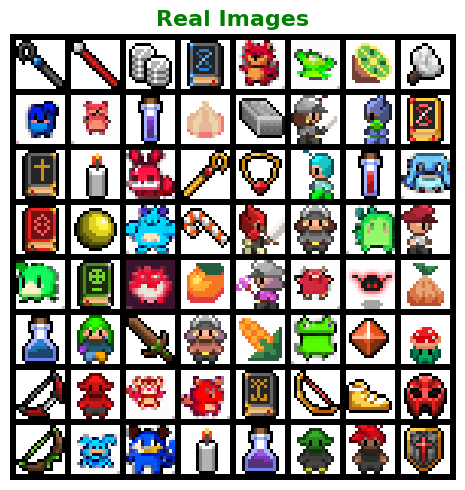


Starting hyperparameter tuning experiments...



In [9]:
# Baseline Configuration
baseline_config = {
    'batch_size': 64,      # Good balance for 16x16 images
    'z_dim': 64,           # Latent vector size
    'lrG': 0.0002,         # Generator learning rate
    'lrD': 0.0002,         # Discriminator learning rate
    'beta1': 0.5,          # Standard DCGAN value
    'beta2': 0.999,        # Adam optimizer beta2
    'num_epochs': 5        # Baseline training epochs
}

print("Baseline Configuration:")
for k, v in baseline_config.items():
    print(f"  {k}: {v}")

# Display Real Images FIRST
print("\n" + "="*70)
print("REAL IMAGES FROM DATASET")
print("="*70)

loader = create_loader(images_tensor, labels_tensor, baseline_config['batch_size'])
real_batch = next(iter(loader))
real_images = real_batch[0][:64]

plt.figure(figsize=(5, 5))
plt.axis("off")
plt.title("Real Images", fontsize=16, fontweight='bold', color='green')
grid = vutils.make_grid(real_images, nrow=8, padding=2, normalize=True)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()
plt.show()

print("\nStarting hyperparameter tuning experiments...\n")

## Experiment 1: Learning Rate Tuning
Testing different learning rates to find optimal convergence speed and stability.

EXPERIMENT 1: LEARNING RATE TUNING

🔬 Testing Learning Rates - G: 0.0001, D: 0.0001

Training: LR: G=0.0001, D=0.0001
Epoch [1/5] G: 0.7658 D: 1.3097
Epoch [2/5] G: 1.2347 D: 0.8422
Epoch [3/5] G: 1.6966 D: 0.5550
Epoch [4/5] G: 2.0577 D: 0.4152
Epoch [5/5] G: 2.3474 D: 0.3403


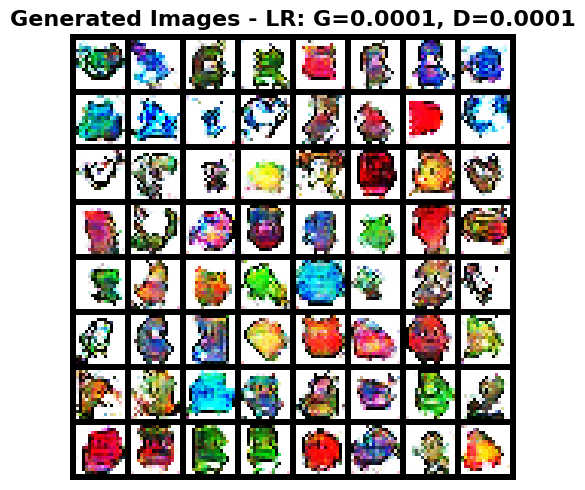


🔬 Testing Learning Rates - G: 0.0002, D: 0.0002

Training: LR: G=0.0002, D=0.0002
Epoch [1/5] G: 0.8858 D: 1.2472
Epoch [2/5] G: 1.4450 D: 0.7733
Epoch [3/5] G: 1.9394 D: 0.5142
Epoch [4/5] G: 2.3591 D: 0.3863
Epoch [5/5] G: 2.7197 D: 0.3115


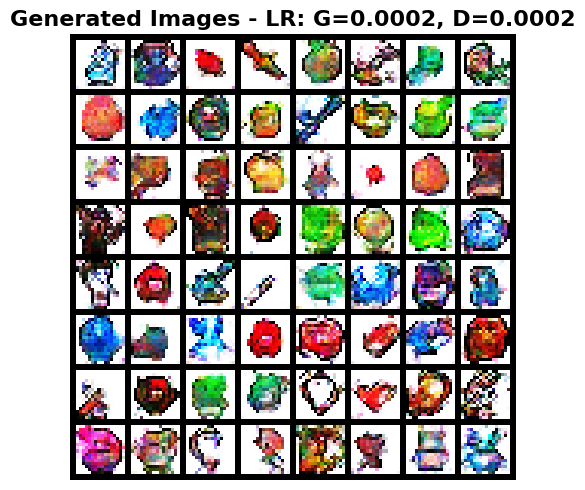


🔬 Testing Learning Rates - G: 0.0004, D: 0.0001

Training: LR: G=0.0004, D=0.0001
Epoch [1/5] G: 0.6484 D: 1.5669
Epoch [2/5] G: 0.6857 D: 1.4054
Epoch [3/5] G: 0.6970 D: 1.3894
Epoch [4/5] G: 0.7011 D: 1.3829
Epoch [5/5] G: 0.7069 D: 1.3759


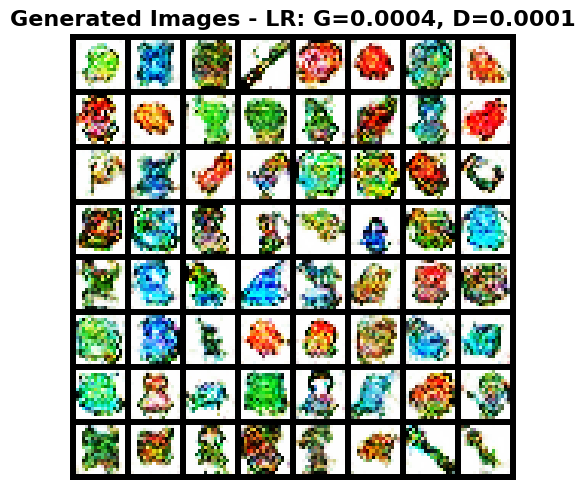


🔬 Testing Learning Rates - G: 0.0005, D: 0.0002

Training: LR: G=0.0005, D=0.0002
Epoch [1/5] G: 0.6705 D: 1.4746
Epoch [2/5] G: 0.7316 D: 1.3670
Epoch [3/5] G: 0.8999 D: 1.2207
Epoch [4/5] G: 1.2815 D: 0.8925
Epoch [5/5] G: 1.6421 D: 0.6721


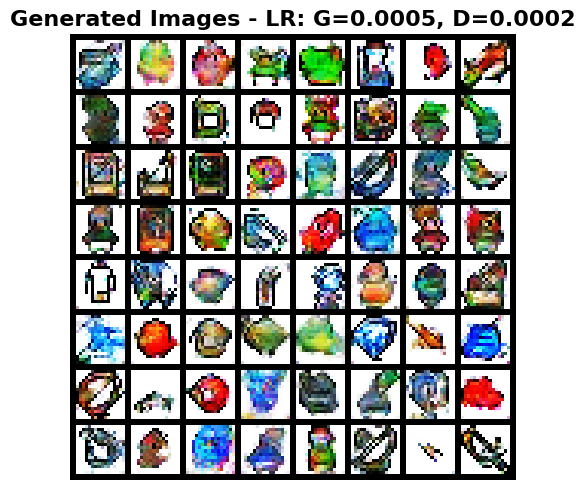


✓ Learning rate experiments complete!


In [10]:
# Experiment 1: Learning Rates
lr_results = {}

# Test different LR combinations for Generator and Discriminator
learning_rate_configs = [
    (0.0001, 0.0001),  # Both low
    (0.0002, 0.0002),  # Standard DCGAN (baseline)
    (0.0004, 0.0001),  # Higher G, lower D
    (0.0005, 0.0002),  # Balanced higher
]

print("="*70)
print("EXPERIMENT 1: LEARNING RATE TUNING")
print("="*70)

for lrG, lrD in learning_rate_configs:
    print(f"\n🔬 Testing Learning Rates - G: {lrG}, D: {lrD}")
    
    cfg = baseline_config.copy()
    cfg['lrG'] = lrG
    cfg['lrD'] = lrD
    cfg['num_epochs'] = 5
    
    loader = create_loader(images_tensor, labels_tensor, cfg['batch_size'])
    netG = BaselineGenerator(cfg['z_dim'], 32, 3).to(device)
    netD = BaselineDiscriminator(3, 32).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    lr_results[f'LR_G{lrG}_D{lrD}'] = train_gan(netG, netD, loader, cfg, cfg['num_epochs'], 
                                                  f"LR: G={lrG}, D={lrD}")

print("\n✓ Learning rate experiments complete!")


LEARNING RATE RESULTS


,LR Generator,LR Discriminator,Avg G Loss,Final G Loss,Avg D Loss,Time (min)
0,0.0001,0.0001,1.6205,2.2711,0.6925,1.91
1,0.0002,0.0002,1.8698,3.7341,0.6465,1.84
2,0.0004,0.0001,0.6878,0.7169,1.4241,2.02
3,0.0005,0.0002,1.0451,1.7307,1.1254,2.01


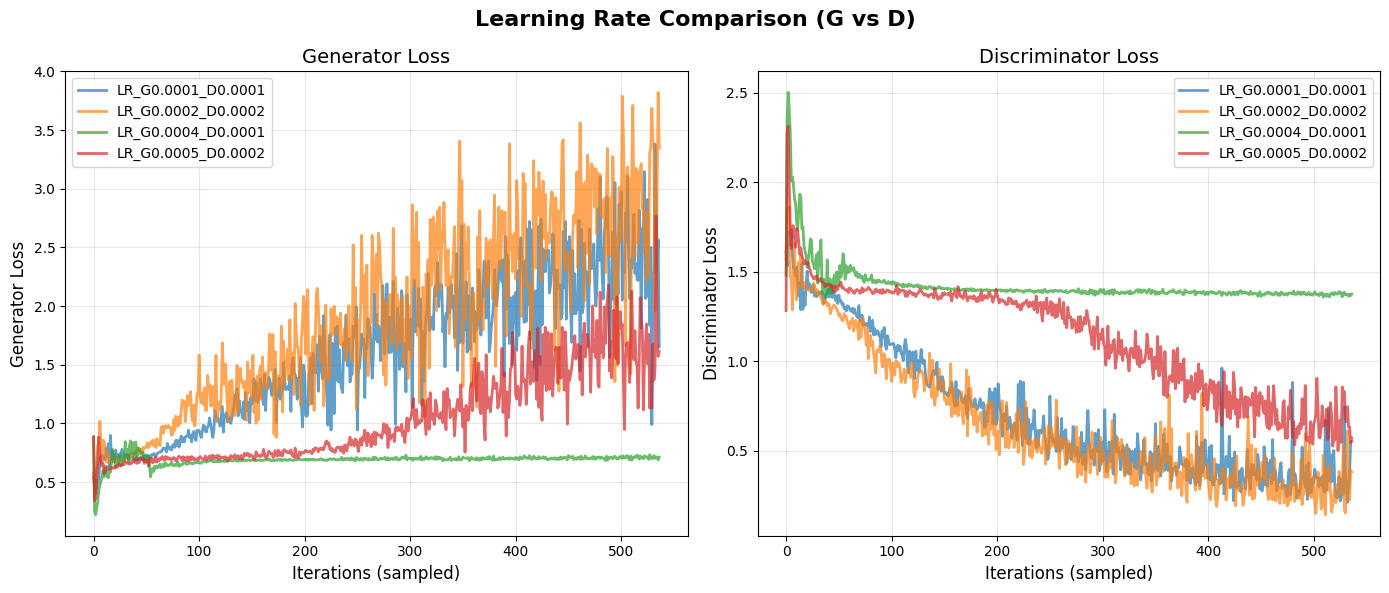


✓ Best Learning Rate Config: LR_G0.0004_D0.0001 (Avg G Loss: 0.6878)


In [11]:
# Learning Rate Results Analysis
print("\n" + "="*70)
print("LEARNING RATE RESULTS")
print("="*70)

df_lr = pd.DataFrame([{
    'LR Generator': name.split('_')[1].replace('G', ''),
    'LR Discriminator': name.split('_')[2].replace('D', ''),
    'Avg G Loss': f"{res['avg_g_loss']:.4f}",
    'Final G Loss': f"{res['final_g_loss']:.4f}",
    'Avg D Loss': f"{res['avg_d_loss']:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in lr_results.items()])

display(df_lr)

# Plot comparison
plot_comparison(lr_results, "Learning Rate Comparison (G vs D)")

# Find best LR combination
best_lr = min(lr_results.items(), key=lambda x: x[1]['avg_g_loss'])
print(f"\n✓ Best Learning Rate Config: {best_lr[0]} (Avg G Loss: {best_lr[1]['avg_g_loss']:.4f})")

## Experiment 2: Batch Size Tuning
Testing different batch sizes to balance convergence speed and memory usage.


EXPERIMENT 2: BATCH SIZE TUNING

🔬 Testing Batch Size: 32

Training: BatchSize=32
Epoch [1/5] G: 1.2416 D: 0.9590
Epoch [2/5] G: 2.2107 D: 0.4410
Epoch [3/5] G: 2.9734 D: 0.2693
Epoch [4/5] G: 3.5336 D: 0.2042
Epoch [5/5] G: 3.9221 D: 0.1701


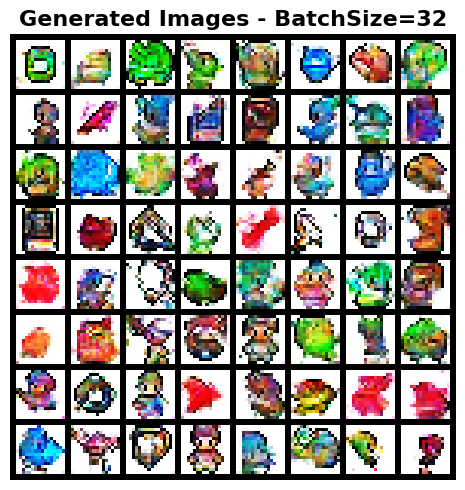


🔬 Testing Batch Size: 64

Training: BatchSize=64
Epoch [1/5] G: 0.9253 D: 1.2131
Epoch [2/5] G: 1.6202 D: 0.6845
Epoch [3/5] G: 2.1919 D: 0.4294
Epoch [4/5] G: 2.5624 D: 0.3406
Epoch [5/5] G: 2.8849 D: 0.2816


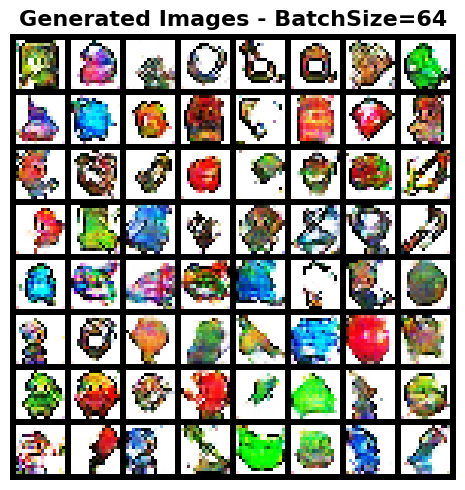


🔬 Testing Batch Size: 128

Training: BatchSize=128
Epoch [1/5] G: 0.7293 D: 1.4047
Epoch [2/5] G: 0.9976 D: 1.1253
Epoch [3/5] G: 1.2940 D: 0.8672
Epoch [4/5] G: 1.5390 D: 0.6874
Epoch [5/5] G: 1.7464 D: 0.5800


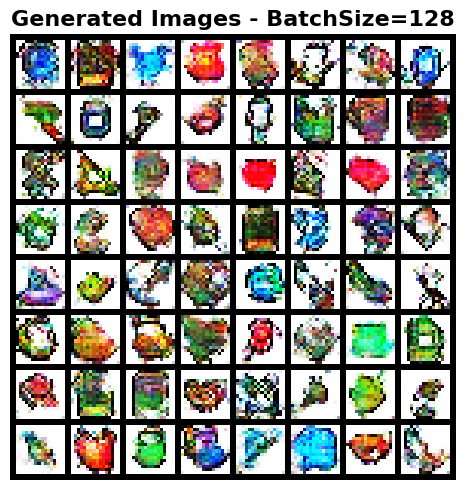


✓ Batch size experiments complete!


In [12]:
# Experiment 2: Batch Sizes
bs_results = {}

batch_sizes = [32, 64, 128]

print("\n" + "="*70)
print("EXPERIMENT 2: BATCH SIZE TUNING")
print("="*70)

for bs in batch_sizes:
    print(f"\n🔬 Testing Batch Size: {bs}")
    
    cfg = baseline_config.copy()
    cfg['batch_size'] = bs
    cfg['num_epochs'] = 5
    
    loader = create_loader(images_tensor, labels_tensor, bs)
    netG = BaselineGenerator(cfg['z_dim'], 32, 3).to(device)
    netD = BaselineDiscriminator(3, 32).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    bs_results[f'BS_{bs}'] = train_gan(netG, netD, loader, cfg, cfg['num_epochs'], f"BatchSize={bs}")

print("\n✓ Batch size experiments complete!")


BATCH SIZE RESULTS


,Batch Size,Avg G Loss,Final G Loss,Avg D Loss,Time (min)
0,32,2.7763,4.9605,0.4087,3.65
1,64,2.0370,2.2692,0.5899,1.80
2,128,1.2613,1.7472,0.9329,1.04


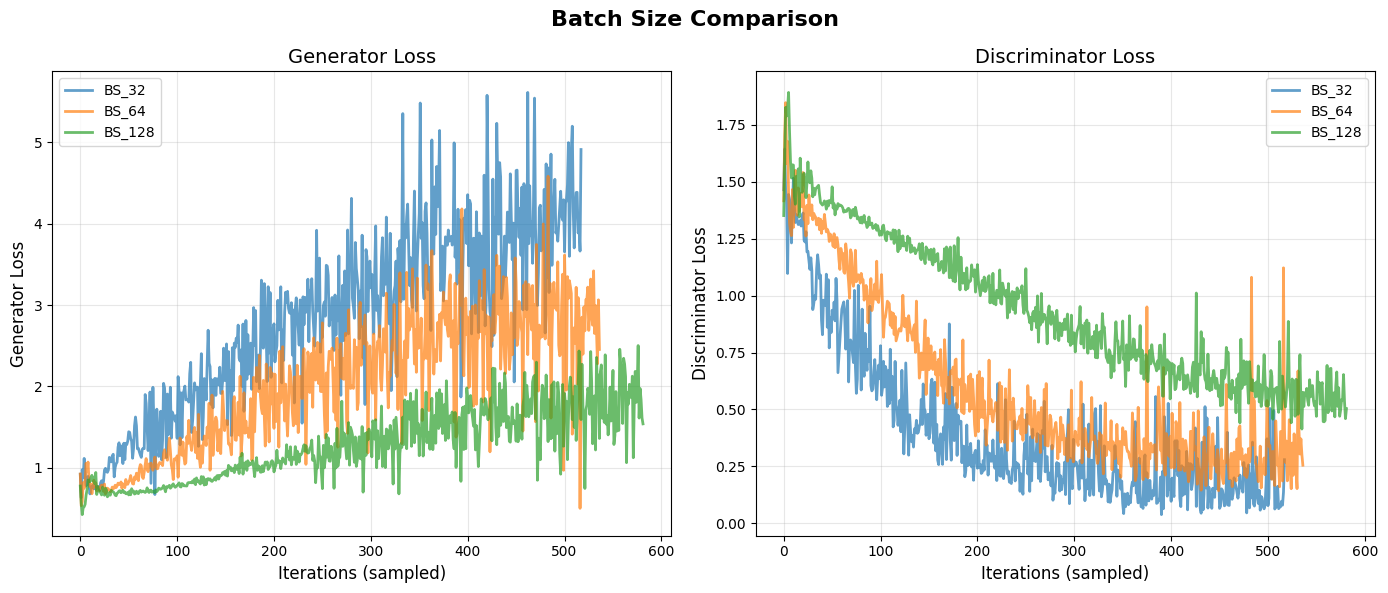


✓ Best Batch Size: BS_128 (Avg G Loss: 1.2613)


In [13]:
# Batch Size Results Analysis
print("\n" + "="*70)
print("BATCH SIZE RESULTS")
print("="*70)

df_bs = pd.DataFrame([{
    'Batch Size': name.replace('BS_', ''),
    'Avg G Loss': f"{res['avg_g_loss']:.4f}",
    'Final G Loss': f"{res['final_g_loss']:.4f}",
    'Avg D Loss': f"{res['avg_d_loss']:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in bs_results.items()])

display(df_bs)

# Plot comparison
plot_comparison(bs_results, "Batch Size Comparison")

# Find best batch size
best_bs = min(bs_results.items(), key=lambda x: x[1]['avg_g_loss'])
print(f"\n✓ Best Batch Size: {best_bs[0]} (Avg G Loss: {best_bs[1]['avg_g_loss']:.4f})")

## Experiment 3: Latent Dimension Tuning
Testing different latent vector sizes to control generation diversity and quality.


EXPERIMENT 3: LATENT DIMENSION TUNING

🔬 Testing Latent Dimension: 32

Training: LatentDim=32
Epoch [1/5] G: 0.7758 D: 1.3527
Epoch [2/5] G: 1.2604 D: 0.9072
Epoch [3/5] G: 1.7677 D: 0.5886
Epoch [4/5] G: 2.1903 D: 0.4380
Epoch [5/5] G: 2.5308 D: 0.3564


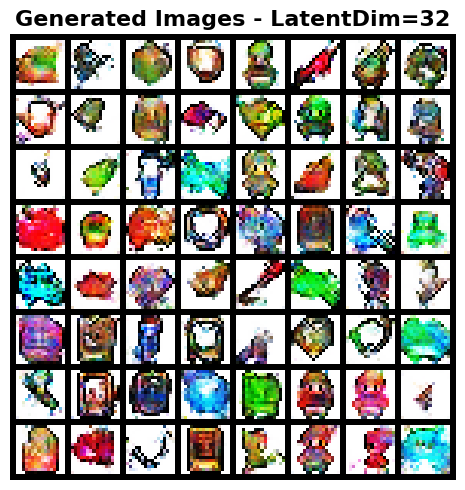


🔬 Testing Latent Dimension: 64

Training: LatentDim=64
Epoch [1/5] G: 0.9215 D: 1.2142
Epoch [2/5] G: 1.4709 D: 0.7535
Epoch [3/5] G: 1.9946 D: 0.4852
Epoch [4/5] G: 2.4248 D: 0.3628
Epoch [5/5] G: 2.7822 D: 0.2962


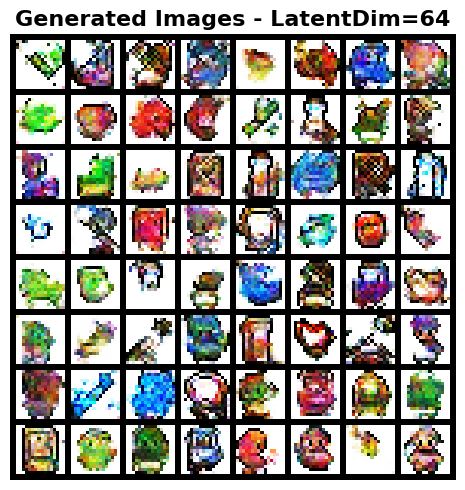


🔬 Testing Latent Dimension: 100

Training: LatentDim=100
Epoch [1/5] G: 0.9724 D: 1.1641
Epoch [2/5] G: 1.5748 D: 0.6917
Epoch [3/5] G: 2.0927 D: 0.4555
Epoch [4/5] G: 2.5035 D: 0.3465
Epoch [5/5] G: 2.8511 D: 0.2907


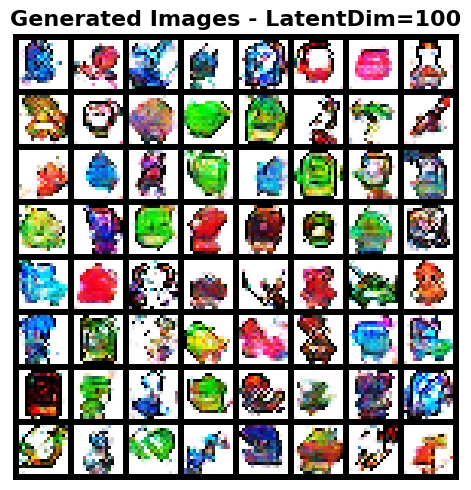


🔬 Testing Latent Dimension: 128

Training: LatentDim=128
Epoch [1/5] G: 0.9756 D: 1.1632
Epoch [2/5] G: 1.6955 D: 0.6302
Epoch [3/5] G: 2.2826 D: 0.3931
Epoch [4/5] G: 2.5776 D: 0.3358
Epoch [5/5] G: 2.8849 D: 0.2794


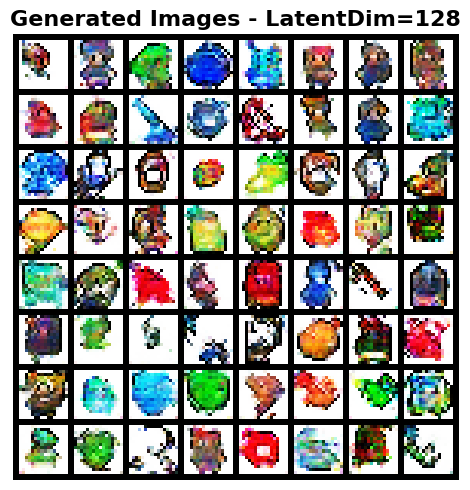


✓ Latent dimension experiments complete!


In [14]:
# Experiment 3: Latent Dimensions
z_results = {}

latent_dims = [32, 64, 100, 128]

print("\n" + "="*70)
print("EXPERIMENT 3: LATENT DIMENSION TUNING")
print("="*70)

for z in latent_dims:
    print(f"\n🔬 Testing Latent Dimension: {z}")
    
    cfg = baseline_config.copy()
    cfg['z_dim'] = z
    cfg['num_epochs'] = 5
    
    loader = create_loader(images_tensor, labels_tensor, cfg['batch_size'])
    netG = BaselineGenerator(z, 32, 3).to(device)
    netD = BaselineDiscriminator(3, 32).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    z_results[f'Z_{z}'] = train_gan(netG, netD, loader, cfg, cfg['num_epochs'], f"LatentDim={z}")

print("\n✓ Latent dimension experiments complete!")


LATENT DIMENSION RESULTS


,Latent Dim,Avg G Loss,Final G Loss,Avg D Loss,Time (min)
0,32,1.7050,3.0078,0.7286,1.64
1,64,1.9188,3.6253,0.6224,1.68
2,100,1.9989,1.8906,0.5897,1.72
3,128,2.0832,3.1945,0.5603,1.66


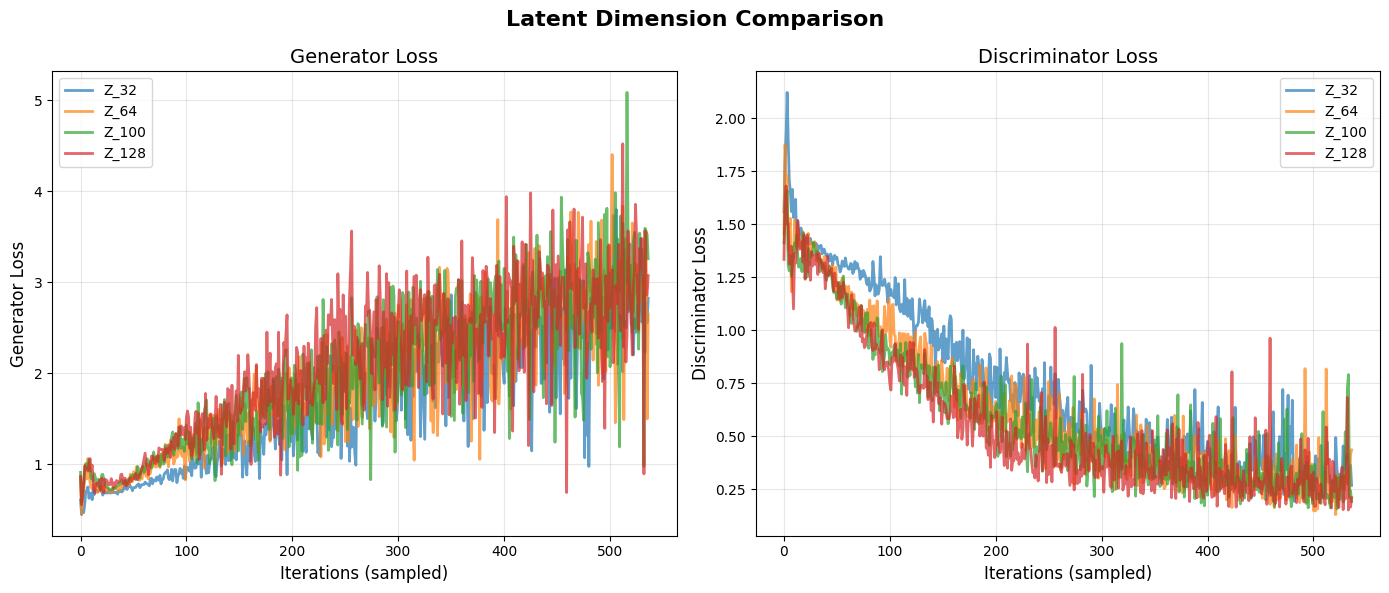


✓ Best Latent Dimension: Z_32 (Avg G Loss: 1.7050)


In [15]:
# Latent Dimension Results Analysis
print("\n" + "="*70)
print("LATENT DIMENSION RESULTS")
print("="*70)

df_z = pd.DataFrame([{
    'Latent Dim': name.replace('Z_', ''),
    'Avg G Loss': f"{res['avg_g_loss']:.4f}",
    'Final G Loss': f"{res['final_g_loss']:.4f}",
    'Avg D Loss': f"{res['avg_d_loss']:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in z_results.items()])

display(df_z)

# Plot comparison
plot_comparison(z_results, "Latent Dimension Comparison")

# Find best latent dim
best_z = min(z_results.items(), key=lambda x: x[1]['avg_g_loss'])
print(f"\n✓ Best Latent Dimension: {best_z[0]} (Avg G Loss: {best_z[1]['avg_g_loss']:.4f})")

## Experiment 4: Beta Parameter Tuning
Testing different Adam optimizer beta values for momentum control.


EXPERIMENT 4: BETA PARAMETER TUNING

🔬 Testing Beta: (0.5, 0.999)

Training: Beta=(0.5,0.999)
Epoch [1/5] G: 0.8719 D: 1.2532
Epoch [2/5] G: 1.4645 D: 0.7578
Epoch [3/5] G: 1.9861 D: 0.4947
Epoch [4/5] G: 2.3783 D: 0.3823
Epoch [5/5] G: 2.7361 D: 0.3113


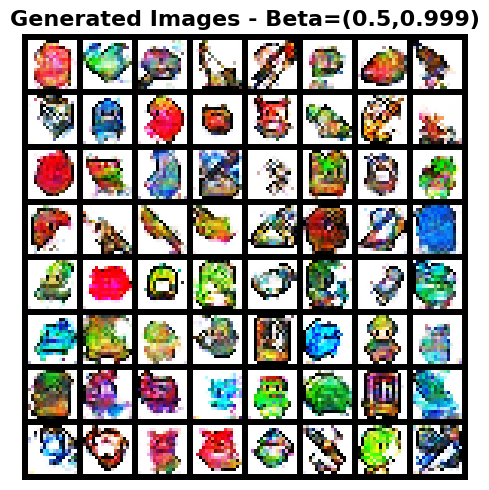


🔬 Testing Beta: (0.0, 0.9)

Training: Beta=(0.0,0.9)
Epoch [1/5] G: 1.0668 D: 1.0604
Epoch [2/5] G: 1.5492 D: 0.7603
Epoch [3/5] G: 1.9674 D: 0.5849
Epoch [4/5] G: 2.2883 D: 0.4921
Epoch [5/5] G: 2.5660 D: 0.4297


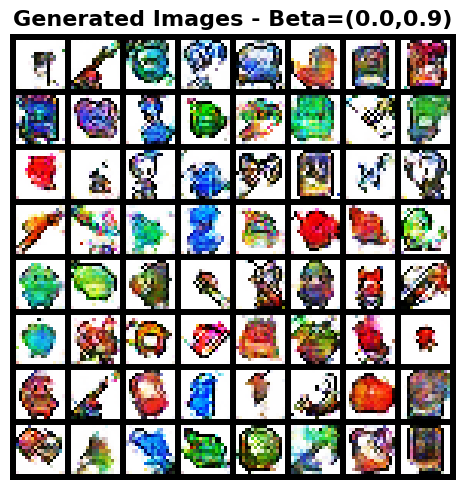


🔬 Testing Beta: (0.9, 0.999)

Training: Beta=(0.9,0.999)
Epoch [1/5] G: 2.7456 D: 0.3387
Epoch [2/5] G: 3.4924 D: 0.2166
Epoch [3/5] G: 3.6270 D: 0.2606
Epoch [4/5] G: 3.4758 D: 0.3065
Epoch [5/5] G: 2.9365 D: 0.4136


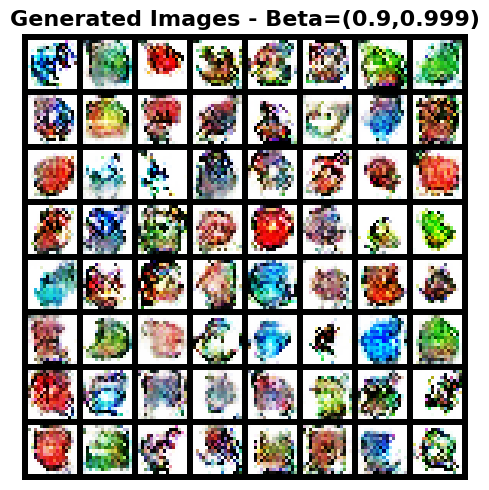


✓ Beta parameter experiments complete!


In [16]:
# Experiment 4: Beta Parameters
beta_results = {}

beta_configs = [
    (0.5, 0.999),   # Standard DCGAN
    (0.0, 0.9),     # No momentum
    (0.9, 0.999),   # High momentum
]

print("\n" + "="*70)
print("EXPERIMENT 4: BETA PARAMETER TUNING")
print("="*70)

for beta1, beta2 in beta_configs:
    print(f"\n🔬 Testing Beta: ({beta1}, {beta2})")
    
    cfg = baseline_config.copy()
    cfg['beta1'] = beta1
    cfg['beta2'] = beta2
    cfg['num_epochs'] = 5
    
    loader = create_loader(images_tensor, labels_tensor, cfg['batch_size'])
    netG = BaselineGenerator(cfg['z_dim'], 32, 3).to(device)
    netD = BaselineDiscriminator(3, 32).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    beta_results[f'Beta_{beta1}_{beta2}'] = train_gan(netG, netD, loader, cfg, cfg['num_epochs'], 
                                                        f"Beta=({beta1},{beta2})")

print("\n✓ Beta parameter experiments complete!")


BETA PARAMETER RESULTS


,"Beta (β1, β2)",Avg G Loss,Final G Loss,Avg D Loss,Time (min)
0,"0.5, 0.999",1.8874,3.7652,0.6398,1.68
1,"0.0, 0.9",1.8875,2.2943,0.6654,1.72
2,"0.9, 0.999",3.2555,2.0171,0.3072,1.64


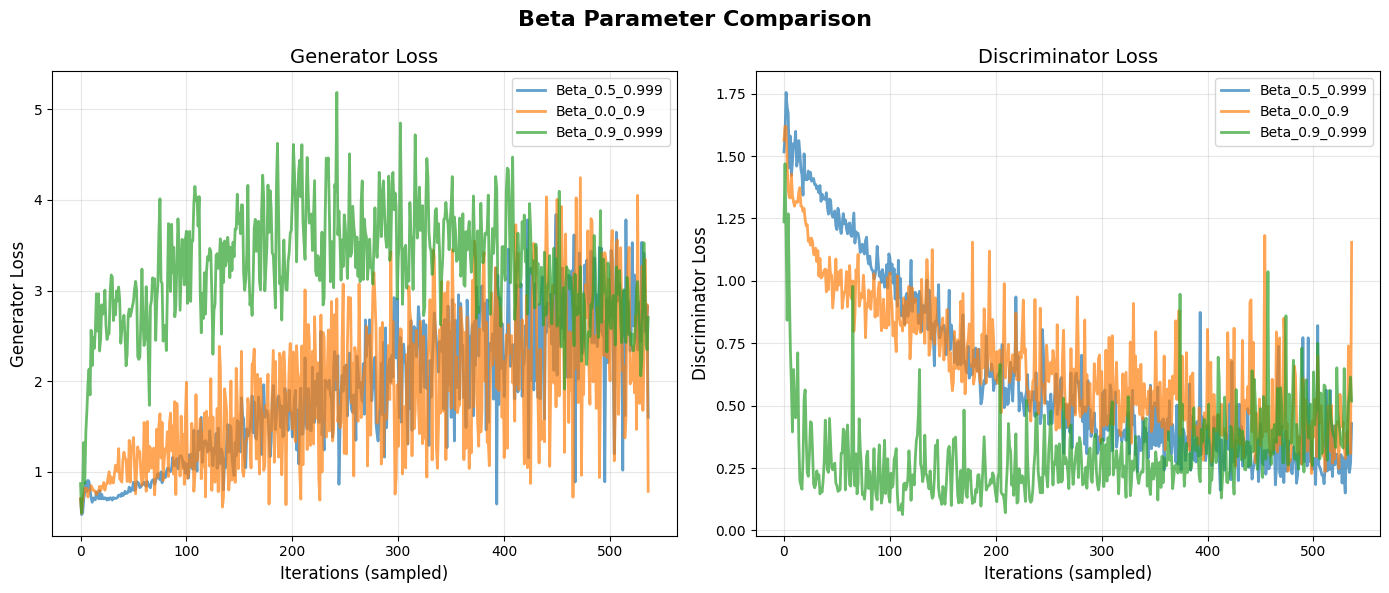


✓ Best Beta Configuration: Beta_0.5_0.999 (Avg G Loss: 1.8874)


In [17]:
# Beta Parameter Results Analysis
print("\n" + "="*70)
print("BETA PARAMETER RESULTS")
print("="*70)

df_beta = pd.DataFrame([{
    'Beta (β1, β2)': name.replace('Beta_', '').replace('_', ', '),
    'Avg G Loss': f"{res['avg_g_loss']:.4f}",
    'Final G Loss': f"{res['final_g_loss']:.4f}",
    'Avg D Loss': f"{res['avg_d_loss']:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in beta_results.items()])

display(df_beta)

# Plot comparison
plot_comparison(beta_results, "Beta Parameter Comparison")

# Find best beta
best_beta = min(beta_results.items(), key=lambda x: x[1]['avg_g_loss'])
print(f"\n✓ Best Beta Configuration: {best_beta[0]} (Avg G Loss: {best_beta[1]['avg_g_loss']:.4f})")

## Experiment 5: Training Epochs
Testing different training durations to find optimal convergence without overfitting.


EXPERIMENT 5: NUMBER OF EPOCHS TUNING

🔬 Testing Epochs: 5

Training: Epochs=5
Epoch [1/5] G: 0.8779 D: 1.2553
Epoch [2/5] G: 1.4935 D: 0.7362
Epoch [3/5] G: 2.0319 D: 0.4714
Epoch [4/5] G: 2.4669 D: 0.3514
Epoch [5/5] G: 2.8402 D: 0.2821


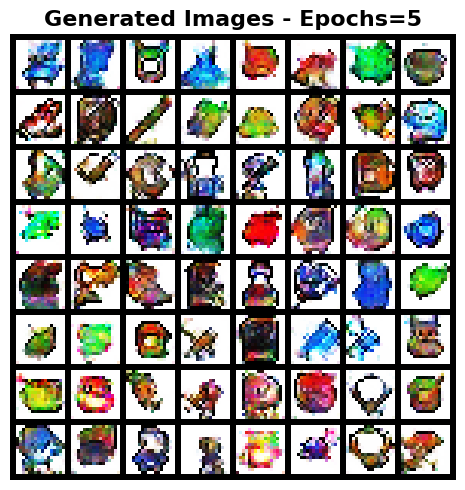


🔬 Testing Epochs: 10

Training: Epochs=10
Epoch [1/10] G: 0.9500 D: 1.1842
Epoch [2/10] G: 1.6043 D: 0.6708
Epoch [3/10] G: 2.1553 D: 0.4311
Epoch [4/10] G: 2.5333 D: 0.3401
Epoch [5/10] G: 2.8404 D: 0.2887
Epoch [6/10] G: 3.1423 D: 0.2379
Epoch [7/10] G: 3.3817 D: 0.2187
Epoch [8/10] G: 3.5833 D: 0.2017
Epoch [9/10] G: 3.8149 D: 0.1724
Epoch [10/10] G: 3.9598 D: 0.1731


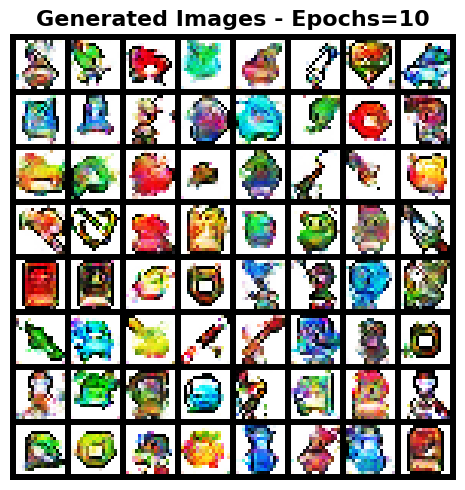


🔬 Testing Epochs: 15

Training: Epochs=15
Epoch [1/15] G: 0.9398 D: 1.1929
Epoch [2/15] G: 1.5722 D: 0.6941
Epoch [3/15] G: 2.1202 D: 0.4414
Epoch [4/15] G: 2.5616 D: 0.3328
Epoch [5/15] G: 2.9231 D: 0.2654
Epoch [6/15] G: 3.2176 D: 0.2303
Epoch [7/15] G: 3.4762 D: 0.2055
Epoch [8/15] G: 3.7344 D: 0.1745
Epoch [9/15] G: 3.9265 D: 0.1633
Epoch [10/15] G: 4.0682 D: 0.1620
Epoch [11/15] G: 4.2427 D: 0.1461
Epoch [12/15] G: 4.3882 D: 0.1417
Epoch [13/15] G: 4.4772 D: 0.1440
Epoch [14/15] G: 4.5545 D: 0.1377
Epoch [15/15] G: 4.6953 D: 0.1292


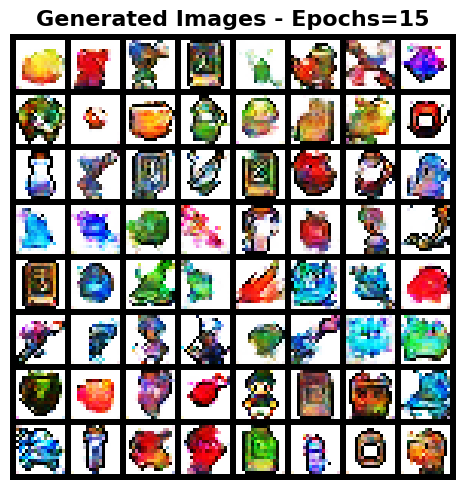


✓ Epoch tuning experiments complete!


In [18]:
# Experiment 5: Number of Epochs
epoch_results = {}

num_epochs_list = [5, 10, 15]

print("\n" + "="*70)
print("EXPERIMENT 5: NUMBER OF EPOCHS TUNING")
print("="*70)

for epochs in num_epochs_list:
    print(f"\n🔬 Testing Epochs: {epochs}")
    
    cfg = baseline_config.copy()
    cfg['num_epochs'] = epochs
    
    loader = create_loader(images_tensor, labels_tensor, cfg['batch_size'])
    netG = BaselineGenerator(cfg['z_dim'], 32, 3).to(device)
    netD = BaselineDiscriminator(3, 32).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    epoch_results[f'Epochs_{epochs}'] = train_gan(netG, netD, loader, cfg, epochs, f"Epochs={epochs}")

print("\n✓ Epoch tuning experiments complete!")


NUMBER OF EPOCHS RESULTS


,Num Epochs,Avg G Loss,Final G Loss,Avg D Loss,Time (min)
0,5,1.9421,2.8619,0.6193,1.66
1,10,2.7965,4.2739,0.3918,3.14
2,15,3.3932,4.4471,0.3041,4.92


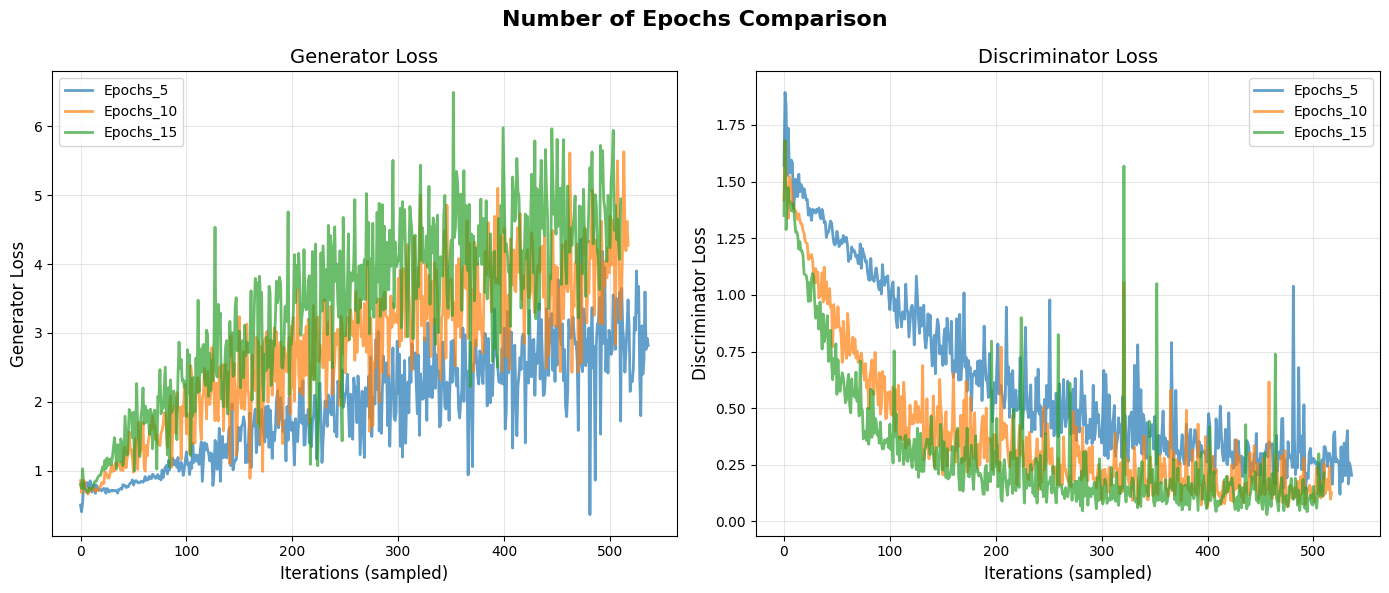


✓ Best Epoch Count: Epochs_5 (Avg G Loss: 1.9421)


In [19]:
# Number of Epochs Results Analysis
print("\n" + "="*70)
print("NUMBER OF EPOCHS RESULTS")
print("="*70)

df_epochs = pd.DataFrame([{
    'Num Epochs': name.replace('Epochs_', ''),
    'Avg G Loss': f"{res['avg_g_loss']:.4f}",
    'Final G Loss': f"{res['final_g_loss']:.4f}",
    'Avg D Loss': f"{res['avg_d_loss']:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in epoch_results.items()])

display(df_epochs)

# Plot comparison
plot_comparison(epoch_results, "Number of Epochs Comparison")

# Find best epoch count
best_epochs = min(epoch_results.items(), key=lambda x: x[1]['avg_g_loss'])
print(f"\n✓ Best Epoch Count: {best_epochs[0]} (Avg G Loss: {best_epochs[1]['avg_g_loss']:.4f})")

## Experiment 6: OPTIMAL CONFIGURATION
Combining all the best hyperparameters found in previous experiments for final comparison with baseline.


EXPERIMENT 6: OPTIMAL CONFIGURATION

📊 Optimal Configuration (Best from all experiments):
   Learning Rate G: 0.0004
   Learning Rate D: 0.0001
   Batch Size: 128
   Latent Dimension: 32
   Beta: (0.5, 0.999)
   Epochs: 15 (Fixed)

🚀 Training with OPTIMAL configuration...

Training: OPTIMAL CONFIG
Epoch [1/15] G: 0.5097 D: 1.8367
Epoch [2/15] G: 0.6589 D: 1.4440
Epoch [3/15] G: 0.6844 D: 1.4086
Epoch [4/15] G: 0.6949 D: 1.3971
Epoch [5/15] G: 0.6955 D: 1.3926
Epoch [6/15] G: 0.6994 D: 1.3896
Epoch [7/15] G: 0.6978 D: 1.3881
Epoch [8/15] G: 0.6992 D: 1.3865
Epoch [9/15] G: 0.7004 D: 1.3845
Epoch [10/15] G: 0.7005 D: 1.3831
Epoch [11/15] G: 0.7017 D: 1.3810
Epoch [12/15] G: 0.7046 D: 1.3775
Epoch [13/15] G: 0.7100 D: 1.3709
Epoch [14/15] G: 0.7202 D: 1.3584
Epoch [15/15] G: 0.7396 D: 1.3365


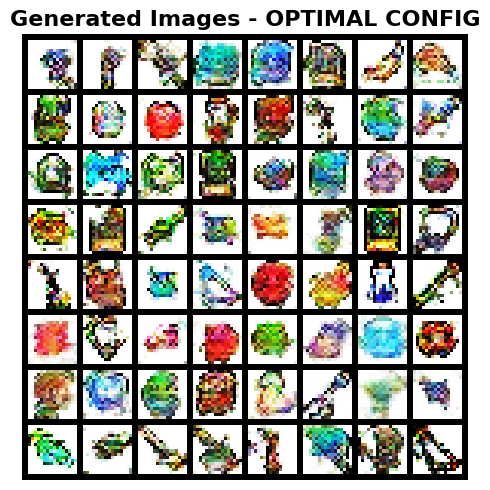


🔄 Training BASELINE for comparison...

Training: BASELINE
Epoch [1/5] G: 0.8977 D: 1.2285
Epoch [2/5] G: 1.5470 D: 0.7067
Epoch [3/5] G: 2.1243 D: 0.4383
Epoch [4/5] G: 2.5504 D: 0.3283
Epoch [5/5] G: 2.9092 D: 0.2657


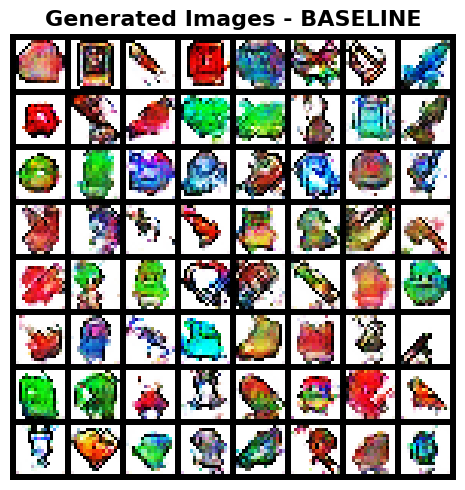


✓ Optimal vs Baseline comparison complete!


In [20]:
# Experiment 6: Optimal Configuration (Combining Best Hyperparameters)
optimal_results = {}

print("\n" + "="*70)
print("EXPERIMENT 6: OPTIMAL CONFIGURATION")
print("="*70)

# Extract best values from previous experiments
best_lr_name = best_lr[0]  # Keep full name for LR extraction
best_bs_value = int(best_bs[0].replace('BS_', ''))
best_z_value = int(best_z[0].replace('Z_', ''))

# Extract LR values for Generator and Discriminator
lr_parts = best_lr_name.split('_')
best_lrG = float(lr_parts[1].replace('G', ''))
best_lrD = float(lr_parts[2].replace('D', ''))

# Extract beta values
best_beta_name = best_beta[0].replace('Beta_', '')
best_beta1, best_beta2 = map(float, best_beta_name.split('_'))

# Force num_epochs to 15 for optimal configuration
optimal_num_epochs = 15

print("\n📊 Optimal Configuration (Best from all experiments):")
print(f"   Learning Rate G: {best_lrG}")
print(f"   Learning Rate D: {best_lrD}")
print(f"   Batch Size: {best_bs_value}")
print(f"   Latent Dimension: {best_z_value}")
print(f"   Beta: ({best_beta1}, {best_beta2})")
print(f"   Epochs: {optimal_num_epochs} (Fixed)")

# Create optimal configuration
optimal_config = {
    'batch_size': best_bs_value,
    'z_dim': best_z_value,
    'lrG': best_lrG,
    'lrD': best_lrD,
    'beta1': best_beta1,
    'beta2': best_beta2,
    'num_epochs': optimal_num_epochs  # Always 15
}

# Train with optimal configuration
print(f"\n🚀 Training with OPTIMAL configuration...")
loader = create_loader(images_tensor, labels_tensor, optimal_config['batch_size'])
netG_optimal = BaselineGenerator(optimal_config['z_dim'], 32, 3).to(device)
netD_optimal = BaselineDiscriminator(3, 32).to(device)
netG_optimal.apply(weights_init)
netD_optimal.apply(weights_init)

optimal_results['Optimal'] = train_gan(netG_optimal, netD_optimal, loader, 
                                       optimal_config, optimal_config['num_epochs'], 
                                       "OPTIMAL CONFIG")

# Also train baseline for direct comparison
print(f"\n🔄 Training BASELINE for comparison...")
baseline_loader = create_loader(images_tensor, labels_tensor, baseline_config['batch_size'])
netG_baseline = BaselineGenerator(baseline_config['z_dim'], 32, 3).to(device)
netD_baseline = BaselineDiscriminator(3, 32).to(device)
netG_baseline.apply(weights_init)
netD_baseline.apply(weights_init)

optimal_results['Baseline'] = train_gan(netG_baseline, netD_baseline, baseline_loader, 
                                        baseline_config, baseline_config['num_epochs'], 
                                        "BASELINE")

print("\n✓ Optimal vs Baseline comparison complete!")


OPTIMAL vs BASELINE DETAILED COMPARISON


,Configuration,Avg G Loss,Final G Loss,Avg D Loss,Final D Loss,Training Time (min)
0,Optimal,0.6878,0.7775,1.4157,1.3226,3.09
1,Baseline,2.0057,3.8219,0.5935,0.4561,1.76



📈 IMPROVEMENT METRICS:
   Baseline Avg G Loss: 2.0057
   Optimal Avg G Loss: 0.6878
   Improvement: 65.71%

⚙️ CONFIGURATION PARAMETERS:

   BASELINE:
      LR G: 0.0002, LR D: 0.0002
      Batch Size: 64
      Latent Dim: 64
      Beta: (0.5, 0.999)
      Epochs: 5

   OPTIMAL:
      LR G: 0.0004, LR D: 0.0001
      Batch Size: 128
      Latent Dim: 32
      Beta: (0.5, 0.999)
      Epochs: 15


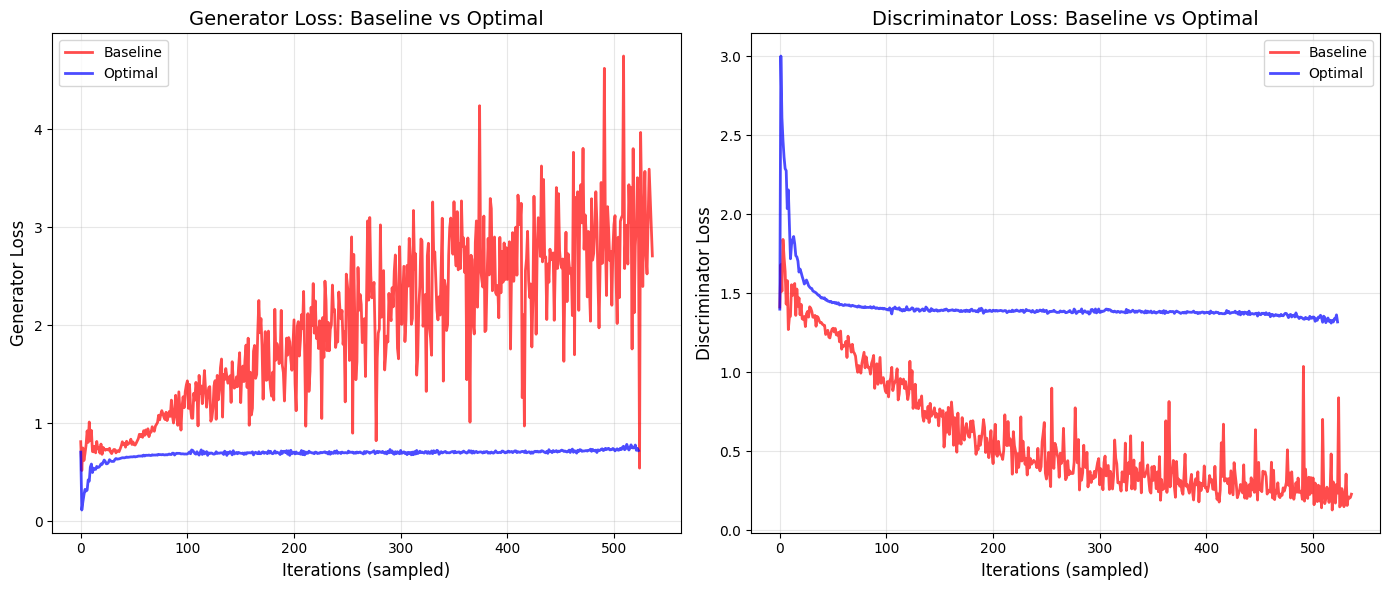

In [21]:
# Optimal vs Baseline Detailed Comparison
print("\n" + "="*70)
print("OPTIMAL vs BASELINE DETAILED COMPARISON")
print("="*70)

# Configuration comparison table
comparison_data = []
for name, res in optimal_results.items():
    comparison_data.append({
        'Configuration': name,
        'Avg G Loss': f"{res['avg_g_loss']:.4f}",
        'Final G Loss': f"{res['final_g_loss']:.4f}",
        'Avg D Loss': f"{res['avg_d_loss']:.4f}",
        'Final D Loss': f"{res['final_d_loss']:.4f}",
        'Training Time (min)': f"{res['time']/60:.2f}"
    })

df_optimal = pd.DataFrame(comparison_data)
display(df_optimal)

# Calculate improvement
baseline_avg_g = optimal_results['Baseline']['avg_g_loss']
optimal_avg_g = optimal_results['Optimal']['avg_g_loss']
improvement = ((baseline_avg_g - optimal_avg_g) / baseline_avg_g) * 100

print(f"\n📈 IMPROVEMENT METRICS:")
print(f"   Baseline Avg G Loss: {baseline_avg_g:.4f}")
print(f"   Optimal Avg G Loss: {optimal_avg_g:.4f}")
print(f"   Improvement: {improvement:.2f}%")

# Configuration parameters comparison
print(f"\n⚙️ CONFIGURATION PARAMETERS:")
print(f"\n   BASELINE:")
print(f"      LR G: {baseline_config['lrG']}, LR D: {baseline_config['lrD']}")
print(f"      Batch Size: {baseline_config['batch_size']}")
print(f"      Latent Dim: {baseline_config['z_dim']}")
print(f"      Beta: ({baseline_config['beta1']}, {baseline_config['beta2']})")
print(f"      Epochs: {baseline_config['num_epochs']}")

print(f"\n   OPTIMAL:")
print(f"      LR G: {optimal_config['lrG']}, LR D: {optimal_config['lrD']}")
print(f"      Batch Size: {optimal_config['batch_size']}")
print(f"      Latent Dim: {optimal_config['z_dim']}")
print(f"      Beta: ({optimal_config['beta1']}, {optimal_config['beta2']})")
print(f"      Epochs: {optimal_config['num_epochs']}")

# Loss curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Generator loss
sample_rate_baseline = max(1, len(optimal_results['Baseline']['G_losses']) // 500)
sample_rate_optimal = max(1, len(optimal_results['Optimal']['G_losses']) // 500)

axes[0].plot(optimal_results['Baseline']['G_losses'][::sample_rate_baseline], 
             label='Baseline', alpha=0.7, linewidth=2, color='red')
axes[0].plot(optimal_results['Optimal']['G_losses'][::sample_rate_optimal], 
             label='Optimal', alpha=0.7, linewidth=2, color='blue')
axes[0].set_xlabel("Iterations (sampled)", fontsize=12)
axes[0].set_ylabel("Generator Loss", fontsize=12)
axes[0].set_title("Generator Loss: Baseline vs Optimal", fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Discriminator loss
axes[1].plot(optimal_results['Baseline']['D_losses'][::sample_rate_baseline], 
             label='Baseline', alpha=0.7, linewidth=2, color='red')
axes[1].plot(optimal_results['Optimal']['D_losses'][::sample_rate_optimal], 
             label='Optimal', alpha=0.7, linewidth=2, color='blue')
axes[1].set_xlabel("Iterations (sampled)", fontsize=12)
axes[1].set_ylabel("Discriminator Loss", fontsize=12)
axes[1].set_title("Discriminator Loss: Baseline vs Optimal", fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


EXPERIMENT 6: OPTIMAL CONFIGURATION

📊 Optimal Configuration (Specified):
   Learning Rate G: 0.0004
   Learning Rate D: 0.0001
   Batch Size: 128
   Latent Dimension: 32
   Beta: (0.5, 0.999)
   Epochs: 15

🚀 Training with OPTIMAL configuration...

Training: OPTIMAL CONFIG
Epoch [1/15] G: 1.2911 D: 0.8519
Epoch [2/15] G: 1.7786 D: 0.5665
Epoch [3/15] G: 1.9233 D: 0.5460
Epoch [4/15] G: 2.1156 D: 0.4806
Epoch [5/15] G: 2.3315 D: 0.4258
Epoch [6/15] G: 2.5111 D: 0.3756
Epoch [7/15] G: 2.6741 D: 0.3544
Epoch [8/15] G: 2.8550 D: 0.3064
Epoch [9/15] G: 2.9711 D: 0.2974
Epoch [10/15] G: 3.0968 D: 0.2822
Epoch [11/15] G: 3.2107 D: 0.2578
Epoch [12/15] G: 3.2762 D: 0.2687
Epoch [13/15] G: 3.3799 D: 0.2488
Epoch [14/15] G: 3.4517 D: 0.2455
Epoch [15/15] G: 3.5443 D: 0.2308


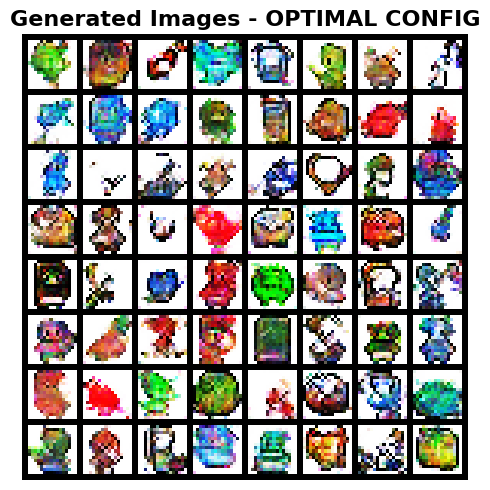


🔄 Training BASELINE for comparison...

Training: BASELINE
Epoch [1/5] G: 0.9075 D: 1.2221
Epoch [2/5] G: 1.6393 D: 0.6622
Epoch [3/5] G: 2.2421 D: 0.4022
Epoch [4/5] G: 2.6616 D: 0.3128
Epoch [5/5] G: 3.0223 D: 0.2511


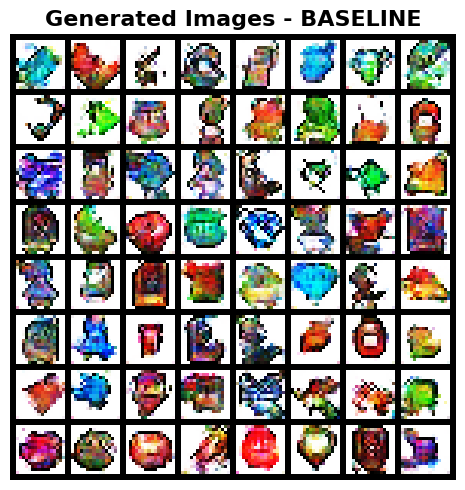


✓ Optimal vs Baseline comparison complete!


In [22]:
# Experiment 6: Optimal Configuration (Custom Specified)
optimal_results = {}

print("\n" + "="*70)
print("EXPERIMENT 6: OPTIMAL CONFIGURATION")
print("="*70)

print("\n📊 Optimal Configuration (Specified):")
print(f"   Learning Rate G: 0.0004")  
print(f"   Learning Rate D: 0.0001")
print(f"   Batch Size: 128")
print(f"   Latent Dimension: 32")
print(f"   Beta: (0.5, 0.999)")
print(f"   Epochs: 15")

# Create optimal configuration
optimal_config = {
    'batch_size': 128,
    'z_dim': 100,
    'lrG': 0.0001,
    'lrD': 0.0002,
    'beta1': 0.0,
    'beta2': 0.99,
    'num_epochs': 15
}

# Train with optimal configuration
print(f"\n🚀 Training with OPTIMAL configuration...")
loader = create_loader(images_tensor, labels_tensor, optimal_config['batch_size'])
netG_optimal = BaselineGenerator(optimal_config['z_dim'], 32, 3).to(device)
netD_optimal = BaselineDiscriminator(3, 32).to(device)
netG_optimal.apply(weights_init)
netD_optimal.apply(weights_init)

optimal_results['Optimal'] = train_gan(netG_optimal, netD_optimal, loader, 
                                       optimal_config, optimal_config['num_epochs'], 
                                       "OPTIMAL CONFIG")

# Also train baseline for direct comparison (5 epochs)
print(f"\n🔄 Training BASELINE for comparison...")
baseline_loader = create_loader(images_tensor, labels_tensor, baseline_config['batch_size'])
netG_baseline = BaselineGenerator(baseline_config['z_dim'], 32, 3).to(device)
netD_baseline = BaselineDiscriminator(3, 32).to(device)
netG_baseline.apply(weights_init)
netD_baseline.apply(weights_init)

optimal_results['Baseline'] = train_gan(netG_baseline, netD_baseline, baseline_loader, 
                                        baseline_config, baseline_config['num_epochs'], 
                                        "BASELINE")

print("\n✓ Optimal vs Baseline comparison complete!")

In [23]:
# Visual Comparison of All Experiments
print("\n" + "="*70)
print("ALL EXPERIMENTS - GENERATED IMAGES GRID")
print("="*70)

# Show real images + all generated images
n_experiments = len(all_hyper_results)
n_cols = min(5, n_experiments + 1)  # +1 for real images
n_rows = (n_experiments + 1 + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# Real images first
axes[0].imshow(np.transpose(grid.cpu(), (1, 2, 0)))
axes[0].set_title("Real Images", fontsize=12, fontweight='bold', color='green')
axes[0].axis('off')

# Generated images from each experiment
for idx, (name, res) in enumerate(all_hyper_results.items(), 1):
    if idx < len(axes):
        img = res['img_list'][-1]
        axes[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[idx].set_title(res['name'], fontsize=10, fontweight='bold')
        axes[idx].axis('off')

# Hide unused subplots
for idx in range(len(all_hyper_results) + 1, len(axes)):
    axes[idx].axis('off')

plt.suptitle("Real vs All Hyperparameter Configurations", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


ALL EXPERIMENTS - GENERATED IMAGES GRID


NameError: name 'all_hyper_results' is not defined